[View in Colaboratory](https://colab.research.google.com/github/prakhar070/MNIST-dataset-using-Tensorflow/blob/master/MLP_scratch.ipynb)

### **Loading the MNIST dataset**

In [0]:
#importing the libraries
import numpy as np
from sklearn.datasets import fetch_mldata

#importing the dataset
mnist = fetch_mldata('MNIST original')
data = mnist.data
target = mnist.target

#declaring X_test,X_train,y_test and y_train
indices = np.random.permutation(len(data))
X_test = data[indices[:int(0.2*len(data))]]
y_test = target[indices[:int(0.2*len(data))]].astype(int)
X_train = data[indices[int(0.2*len(data)):]]
y_train = target[indices[int(0.2*len(data)):]].astype(int)

In [9]:
#observing the shape of the loaded data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(56000, 784)
(14000, 784)
(56000,)
(14000,)


**Preprocessing**

In [10]:
#using scikitlearn's standard scaler to scale the feature set
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

#casting to float32 so that it can be used in tensorflow easily
X_train_scaled = np.array(X_train_scaled, dtype="float32")
X_test_scaled = np.array(X_test_scaled, dtype="float32")

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### **Training	a	DNN	Using	Plain	TensorFlow **

If	you	want	more	control	over	the	architecture	of	the	network,	you	may	prefer	to	use	TensorFlow’s	lowerlevel	Python	API	.	In	this	section	we	will	build	the	same	model	as	before	using this	API,	and	we	will	implement	Mini-batch	Gradient	Descent	to	train	it	on	the	MNIST	dataset.	The	first step	is	the	construction	phase,	building	the	TensorFlow	graph.	The	second	step	is	the	execution	phase, where	you	actually	run	the	graph	to	train	the	model

**Construction phase**

In [0]:
import tensorflow as tf

n_inputs = 28*28    #MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

#declaring the placeholder for the input layer
X = tf.placeholder(tf.float32, shape=(None,n_inputs), name="X")
#declaring the placeholder for the output layer
y =tf.placeholder(tf.int64, shape=(None), name="y")

**Now	let’s	create	the	actual	neural	network.	The	placeholder	X	will	act	as	the	input	layer;	during	the execution	phase,	it	will	be	replaced	with	one	training	batch	at	a	time	(note	that	all	the	instances	in	a training	batch	will	be	processed	simultaneously	by	the	neural	network).	Now	you	need	to	create	the	two hidden	layers	and	the	output	layer.	The	two	hidden	layers	are	almost	identical:	they	differ	only	by	the inputs	they	are	connected	to	and	by	the	number	of	neurons	they	contain.	The	output	layer	is	also	very similar,	but	it	uses	a	softmax	activation	function	instead	of	a	ReLU	activation	function.	**

In [0]:
#X is the input vector to that particular neuron layer
#n_neurons is the number of neurons in that very layer
#activation is the step function applied by the LTU's to the weighted sum
def neuron_layer(X, n_neurons, name, activation=None):
  with tf.name_scope(name):
    n_inputs = int(X.shape[1])
    #creating a weight matrics and randomly initializing it
    stddev	=	2	/	np.sqrt(n_inputs)
    init = tf.truncated_normal((n_inputs,	n_neurons),	stddev=stddev)								
    W	=	tf.Variable(init,	name="weights")
    #creating the bias vector
    b = tf.Variable(tf.zeros([n_neurons]), name="biases")
    z = tf.matmul(X,W)+b
    if activation == "relu":
      return tf.nn.relu(z)
    else:
      return z
    
  

Okay,	so	now	you	have	a	nice	function	to	create	a	neuron	layer.	Let’s	use	it	to	create	the	deep	neural network!	**The	first	hidden	layer	takes	X	as	its	input.	The	second	takes	the	output	of	the	first	hidden	layer	as its	input.	And	finally,	the	output	layer	takes	the	output	of	the	second	hidden	layer	as	its	input.**


In [0]:
import numpy as np
#declaring the structure of the deep neural network
with tf.name_scope("dnn"):
  hidden1 = neuron_layer(X, n_hidden1, "hidden1", activation="relu")
  hidden2 = neuron_layer(hidden1, n_hidden2, "hidden2", activation="relu")
  #logits	is	the	output	of	the	neural network	before going through the	softmax	activation	function
  logits = neuron_layer(hidden2, n_outputs, "outputs") 

In [14]:
#declaring the loss function
with tf.name_scope("loss"):
  print(y.shape)
  xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,	logits=logits)
  #finding the loss by using mean of the entropy losses for each y
  loss = tf.reduce_mean(xentropy, name="loss")
  

<unknown>


In [0]:
#training the model using gradient descent to minimize the loss function earlier evaluated
learning_rate = 0.01
with tf.name_scope("train"):
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  training_op = optimizer.minimize(loss)
  
#evaluating the model i.e finding the score of the model  
with tf.name_scope("eval"):
  correct = tf.nn.in_top_k(logits,y,1)
  accuracy = tf.reduce_mean(tf.cast(correct,	tf.float32))

In [0]:
#now we run the graph we have been creating all this while
init = tf.global_variables_initializer()
#execution phase
n_epochs = 200
batch_size = 100
stats_train = []
stats_test = []
with tf.Session() as sess:
  #this initializes all the tf.variables we have declared previously
  init.run()
  for epoch in range(n_epochs):
    #for every iteration
    for batch_no in range(len(X_train)//batch_size):
      X_batch = X_train_scaled[(batch_no*batch_size):((batch_no+1)*batch_size)] 
      y_batch = y_train[(batch_no*batch_size):((batch_no+1)*batch_size)]
      #training the model using the current batch
      sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
    #checking the score after every iteration
    acc_train = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
    acc_test = accuracy.eval(feed_dict={X:X_test_scaled, y:y_test})
    stats_train.append(acc_train)
    stats_test.append(acc_test)
    #print("at iteration number: ",epoch," train accuracy is: ",acc_train," and test accuracy is: ",acc_test)

[]

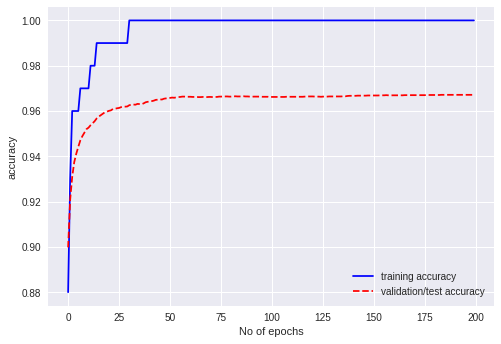

In [18]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0,200), stats_train, "b-", label="training accuracy")
plt.plot(np.arange(0,200), stats_test, "r--", label="validation/test accuracy")
plt.xlabel("No of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.plot()

In [19]:
#printing the maximum test accuracy
print(np.max(stats_test))

0.9671429
